# Wild Drone LLM Workshop: Part 2 - Drone Safari Command Agent

Welcome to Part 2! Now that you understand how LLMs work and how tools give them superpowers, let's apply this to a fun game scenario.

## What You'll Build

A smart drone command agent that:
- Understands natural language instructions
- Translates them into precise game actions
- Navigates a safari environment safely
- Helps you photograph wildlife

## The Drone Safari Game

You control a drone in a 20x20 grid safari park. Your mission:
- **Navigate safely** - Avoid trees and boundaries
- **Find animals** - Zebras, elephants, and oryx roam the park  
- **Take photos** - You have 5 pictures to capture all 3 species
- **Stay alert** - Get too close and animals will run away!

## Learning Journey

1. **Explore the Game** - Understand the safari environment
2. **Build Basic Agent** - Create a drone that follows simple commands
3. **Add Tools** - Give your agent game actions
4. **Test Commands** - See how natural language becomes game moves
5. **Experiment** - Try different prompts and strategies

Let's start exploring! 🚁🦓🐘

## Setup: Import Required Modules

You need the same **Gemini API key** from Part 1. If you completed Part 1, you should be all set!

**Quick Setup:**
1. Your `.env` file should already have: `GEMINI_API_KEY=your_key_here`
2. Run the cells below
3. Start playing!

**If Part 1 wasn't completed:** Set your API key in terminal: `export GEMINI_API_KEY=your_key_here`

In [3]:
# Install required packages (same as Part 1)
!pip install litellm matplotlib numpy python-dotenv ipywidgets

# Note: If using OpenAI instead of Gemini, also install:
# !pip install openai

Defaulting to user installation because normal site-packages is not writeable


In [4]:
# Configuration and Setup
import os
import litellm
from dotenv import load_dotenv
from llm_agents import add_parameters_schema, LLMAgent
from drone_safari_game import DroneSafariGame

# Load environment variables from .env file (if it exists)
load_dotenv()

# MODEL CONFIGURATION
# Get Gemini API key from environment variable
gemini_api_key = os.getenv('GEMINI_API_KEY')
# Set the API key for litellm
os.environ['GEMINI_API_KEY'] = gemini_api_key
# Set the model to use throughout the workshop
model_name = "gemini/gemini-1.5-flash"  # Using stable model

In [31]:
# Game Interface
# This creates a simple button interface to help you understand the game mechanics

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
from matplotlib.patches import Rectangle
import threading
import time

class GameInterface:
    """Simple button-controlled interface for the drone safari game"""
    
    def __init__(self, game):
        """Initialize with a game instance"""
        self.game = game
        self.game.__init__()  # Reset game state
        self.output_area = widgets.Output()
        self.result_area = widgets.Output()
        
    def create_interface(self):
        """Create the button-controlled interface"""
        # Create control buttons
        move_forward_btn = widgets.Button(description="↑ Forward", button_style='info', layout=widgets.Layout(width='90px'))
        move_left_btn = widgets.Button(description="← Left", button_style='info', layout=widgets.Layout(width='90px'))
        move_right_btn = widgets.Button(description="→ Right", button_style='info', layout=widgets.Layout(width='90px'))
        move_backward_btn = widgets.Button(description="↓ Backward", button_style='info', layout=widgets.Layout(width='90px'))
        
        turn_left_btn = widgets.Button(description="⟲ Turn L", button_style='warning', layout=widgets.Layout(width='90px'))
        turn_right_btn = widgets.Button(description="⟳ Turn R", button_style='warning', layout=widgets.Layout(width='90px'))
        
        take_picture_btn = widgets.Button(description="📷 Photo", button_style='', layout=widgets.Layout(width='90px'))
        restart_btn = widgets.Button(description="🔄 Restart", button_style='danger', layout=widgets.Layout(width='90px'))
        
        # Set up button handlers
        move_forward_btn.on_click(lambda b: self._handle_action('move', 'forward'))
        move_left_btn.on_click(lambda b: self._handle_action('move', 'left'))
        move_right_btn.on_click(lambda b: self._handle_action('move', 'right'))
        move_backward_btn.on_click(lambda b: self._handle_action('move', 'backward'))
        turn_left_btn.on_click(lambda b: self._handle_action('turn', 'left'))
        turn_right_btn.on_click(lambda b: self._handle_action('turn', 'right'))
        take_picture_btn.on_click(lambda b: self._handle_action('picture', ''))
        restart_btn.on_click(lambda b: self._handle_action('restart', ''))
        
        # Create layout - reorganized as requested
        row1 = widgets.HBox([turn_left_btn, move_forward_btn, turn_right_btn])
        row2 = widgets.HBox([move_left_btn, take_picture_btn, move_right_btn])
        row3 = widgets.HBox([restart_btn, move_backward_btn, widgets.HTML(value="<div style='width:90px'></div>")])
        
        button_controls = widgets.VBox([
            row1, row2, row3
        ])
        
        # Create the main interface
        interface = widgets.VBox([
            self.output_area,
            self.result_area,
            button_controls
        ])
        
        # Show initial state
        with self.output_area:
            self._show_game_state()
            
        with self.result_area:
            print("🎮 Ready to play! Movement is relative to where the drone is facing.")
            
        display(interface)
        
    def _handle_action(self, action_type, direction):
        """Handle game actions"""
        try:
            if action_type == 'move':
                result = self.game.move(direction)
            elif action_type == 'turn':
                result = self.game.turn(direction)
            elif action_type == 'picture':
                result = self.game.take_picture()
            elif action_type == 'restart':
                self.game.__init__()
                result = "🔄 Game restarted!"
            else:
                result = "Unknown action"
                
            # Update display
            with self.output_area:
                clear_output(wait=True)
                self._show_game_state()
                
            with self.result_area:
                clear_output(wait=True)
                print(f"🎮 {result}")
                        
        except Exception as e:
            with self.result_area:
                clear_output(wait=True)
                print(f"❌ Error: {e}")
    
    def _show_game_state(self):
        """Display the current game state"""
        # Clear matplotlib state
        plt.ioff()
        plt.close('all')
        
        # Create visualization
        fig = self.game.visualize(figsize=(8, 6))
        
        # Show and close
        plt.show()
        plt.close(fig)

print("✅ Button Game Interface loaded successfully!")

✅ Button Game Interface loaded successfully!


In [57]:
# Interactive Agent Class Definition (Enhanced with Debug Output)
# This creates an interactive interface for testing your command agent

import matplotlib.pyplot as plt
import matplotlib
# Ensure we're using the right backend for Jupyter
matplotlib.use('module://matplotlib_inline.backend_inline')

class NLGameInterface:
    """Interactive widget for Jupyter notebooks to test command agents"""
    
    def __init__(self, title, game, agent):
        """Initialize with a game instance and an agent"""
        self.title = title
        self.game = game
        self.agent = agent
        self.history = []
        self.interface_created = False

        # Call the init method on the game to ensure it's properly set up
        self.game.__init__()
        
        try:
            from IPython.display import display, clear_output
            import ipywidgets as widgets
            self.display = display
            self.clear_output = clear_output
            self.widgets = widgets
            self.ipython_available = True
        except ImportError:
            print("Warning: IPython widgets not available. Please install jupyter widgets:")
            print("pip install ipywidgets")
            self.ipython_available = False
    
    def create_interface(self):
        """Create the interactive interface"""
        if not self.ipython_available:
            print("Interactive interface not available. Please install ipywidgets.")
            return
        
        # Prevent creating multiple interfaces
        if self.interface_created:
            print("🔄 Interface already created! Use the existing interface above.")
            return
            
        # Create widgets
        self.command_input = self.widgets.Text(
            placeholder="Enter command (e.g., 'move forward', 'turn left', 'take picture')",
            description="Command:",
            style={'description_width': 'initial'},
            layout=self.widgets.Layout(width='450px'),
            continuous_update=False  # This prevents constant updates
        )
        
        self.send_button = self.widgets.Button(
            description="Send Command",
            button_style='primary',
            layout=self.widgets.Layout(width='120px')
        )
        
        self.restart_button = self.widgets.Button(
            description="Restart",
            button_style='warning',
            layout=self.widgets.Layout(width='120px')
        )
        
        self.output_area = self.widgets.Output()
        
        # Set up event handlers - using the modern approach
        self.command_input.observe(self._on_command_change, names='value')
        self.send_button.on_click(self._on_send_click)
        self.restart_button.on_click(self._on_restart_click)
        
        # Create layout
        input_box = self.widgets.HBox([self.command_input, self.send_button, self.restart_button])
        interface = self.widgets.VBox([
            self.widgets.HTML(f"<h3>🚁 {self.title}</h3>"),
            input_box,
            self.output_area
        ])
        
        # Display initial state
        with self.output_area:
            self._show_initial_state()
        
        self.display(interface)
        self.interface_created = True
        # DO NOT RETURN INTERFACE TO PREVENT DUPLICATE DISPLAYS
        # return interface
    
    def _on_command_change(self, change):
        """Handle Enter key press in command input (modern approach)"""
        # Only process if this was triggered by Enter key (when value actually changes)
        if change['type'] == 'change' and change['name'] == 'value':
            self._process_command()
    
    def _on_send_click(self, button):
        """Handle send button click"""
        self._process_command()
    
    def _on_restart_click(self, button):
        """Handle restart button click"""
        # Reset the game to initial state
        self.game.__init__()  # Reinitialize the game
        self.history = []  # Clear command history
        
        # Clear and refresh the display
        with self.output_area:
            self.clear_output(wait=True)
            print("🔄 Game Restarted!")
            print("="*50)
            self._show_initial_state()
    
    def _process_command(self):
        """Process the command and update display"""
        command = self.command_input.value.strip()
        if not command:
            return
        
        try:
            # Get agent response with debug information
            if hasattr(self.agent, 'chat_with_debug'):
                # Use the new debug method if available
                response, debug_output = self.agent.chat_with_debug(command, debug=True, clear_memory=False)
            else:
                # Fallback to regular chat method
                response = self.agent.chat(command)
                debug_output = []

            # Clear output as we received the response
            with self.output_area:
                self.clear_output(wait=True)
            
            # Get game status
            status = self.game.get_status()
            
            # Store in history
            self.history.append({
                'command': command,
                'response': response,
                'debug_output': debug_output,
                'status': status
            })
            
            # Update display
            with self.output_area:
                self.clear_output(wait=True)
                self._show_command_result(command, response, debug_output, status)
                
        except Exception as e:
            with self.output_area:
                self.clear_output(wait=True)
                print(f"❌ Error processing command: {e}")
                print("Please try again with a different command.")
                import traceback
                print("Debug traceback:")
                print(traceback.format_exc())
        
        # Clear input for next command
        self.command_input.value = ""
    
    def _show_initial_state(self):
        """Show the initial game state"""
        
        # Completely clear matplotlib state
        plt.ioff()  # Turn off interactive mode
        plt.close('all')  # Close all figures
        
        # Create the visualization
        fig = self.game.visualize(figsize=(6, 6))
        
        # Explicitly show and then close the figure to prevent accumulation
        plt.show()
        plt.close(fig)
    
    def _show_command_result(self, command, response, debug_output, status):
        """Show the result of a command with debug information"""
        
        # Show debug information if available
        if debug_output:
            print("🔍 Agent Debug Information:")
            for debug_line in debug_output:
                print(debug_line)
        
        # Completely clear matplotlib state
        plt.ioff()  # Turn off interactive mode
        plt.close('all')  # Close all figures
        
        # Create the visualization
        fig = self.game.visualize(figsize=(6, 6))
        
        # Explicitly show and then close the figure to prevent accumulation
        plt.show()
        plt.close(fig)

print("✅ Interactive Agent Class (Enhanced with Debug Output) loaded successfully!")

✅ Interactive Agent Class (Enhanced with Debug Output) loaded successfully!


# Understanding the Drone Safari Game

## First: Play the Game Yourself! 🎮

Before building an AI agent, let's experience the game directly. Below you'll find a **game interface** that lets you play the drone safari game using clickable buttons:

- **Arrow buttons** for movement (↑↓←→)
- **Turn buttons** for rotating left/right  
- **Photo button** to take pictures
- **Restart button** to start over

This hands-on experience will help you understand:
- How the drone moves and turns
- The challenge of photographing animals from exactly 2 cells away
- The consequences of crashes and getting too close to animals
- The strategy needed to complete the mission

## Then: Explore the Game Programmatically

After playing, we'll explore the game through code to understand what your AI agent needs to accomplish!

In [50]:
# 🎮 Try the Game with Button Controls!
# This gives you a hands-on experience with the game mechanics

# Create a new game instance for button control
button_game = DroneSafariGame()

# Create the button interface
button_interface = GameInterface(button_game)
button_interface.create_interface()

Action 1: Moved forward to position (7, 6), facing North
Action 2: Turned right, now facing East
Action 3: Picture #1 wasted! No animal in range to photograph. 4 pictures remaining.

🗺️ Safari Map:


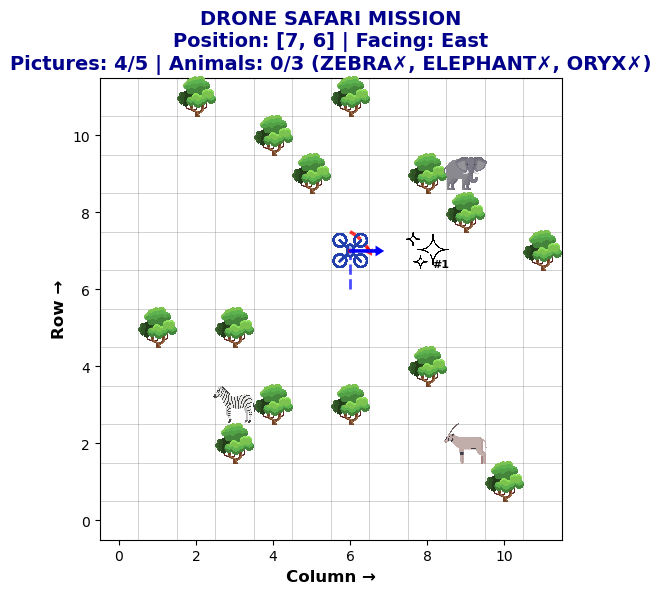

In [51]:
# Create a safari game and explore it
game = DroneSafariGame()

# This is how you programatically interact with the game
# Each action returns a string describing the result of the action so that the agent can understand what happened

# Moving
result = game.move('forward') # either 'forward', 'backward', 'left', 'right'
print(f"Action 1: {result}")

# Turning
result = game.turn('right') # either 'left' or 'right'
print(f"Action 2: {result}")

# Take picture
result = game.take_picture()
print(f"Action 3: {result}")

# Visualize the game state, you can see a trace of the past actions in the visualization
print("\n🗺️ Safari Map:")
game.visualize(figsize=(8, 6))

## Building Your Natural Language Command Agent

**Why This Matters:**
Game accessibility is a real challenge. 
Many people struggle with traditional game controllers or complex keyboard commands due to motor disabilities, visual impairments, or cognitive differences. 
Natural language interfaces can make games accessible to everyone.

**The Vision:**
Instead of memorizing button combinations or function calls, control your drone with simple phrases:
- "Move forward" instead of `game.move('forward')`
- "Turn left" instead of `game.turn('left')`
- "Take a picture" instead of `game.take_picture()`

**Real-World Impact:**
This approach creates assistive technology that helps:
- **Motor accessibility** - Control games without precise hand movements
- **Visual accessibility** - Voice control when screen navigation is difficult
- **Cognitive accessibility** - Simple commands instead of complex key combinations
- **Gaming inclusion** - Remove barriers that prevent people from enjoying games

**Your Mission:**
Create an AI agent that translates human language into game actions, making the drone safari accessible through natural voice commands.



## Step 1: Define the tools the agent has access to
To interact with the game, we need tools for:
- Moving between cells
- Turning to face different directions
- Taking a picture

In [52]:
# Tool 1: Drone Movement
@add_parameters_schema(
    move_type={"type": "string", "description": "Movement type: 'forward', 'backward', 'left', 'right'"},
)
def drone_move(move_type: str) -> str:
    """Move the drone in the specified move_type"""
    result = game.move(move_type)

    return result

# Test the tool
print("🚁 Testing drone movement:")
print(drone_move('forward'))

🚁 Testing drone movement:
Moved forward to position (7, 7), facing East


In [53]:
# Tool 2: Drone Turning
@add_parameters_schema(
    turn_direction={"type": "string", "description": "Turn direction: 'left' or 'right'"}
)
def drone_turn(turn_direction: str) -> str:
    """Turn the drone left or right"""
    result = game.turn(turn_direction)

    return result

# Test the tool
print("🔄 Testing drone turning:")
print(drone_turn('right'))

🔄 Testing drone turning:
Turned right, now facing South


In [54]:
# Tool 3: Taking Pictures
@add_parameters_schema()
def drone_take_picture() -> str:
    """Take a picture with the drone camera"""
    result = game.take_picture()
    
    return result

# Test the tool
print("📷 Testing drone camera:")
print(drone_take_picture())

📷 Testing drone camera:
Picture #2 wasted! No animal in range to photograph. 3 pictures remaining.


## Step 2: Create Your Natural Command Agent

Now we'll create an agent that translates your natural language commands into precise game actions. The key insight:

**🧠 YOU make the strategy decisions**  
**🤖 The AGENT translates your words into actions**

Your agent should:
1. **Listen** to natural language commands
2. **Choose** the right tool (move, turn, or take picture)  
3. **Execute** exactly ONE action
4. **Report** what it did

> **🎯 Keep it Simple**: The agent doesn't need to know game strategy - that's your job! It just needs to understand commands like "move forward", "turn left", "take a picture".

In [61]:
# TODO: STUDENT TASK - Create your Natural Command Agent

# Reset the game for a fresh start
game = DroneSafariGame()

# 1. Create a new agent (we'll reuse LLMAgent class)
drone_command_agent = LLMAgent(model=model_name)

# 2. Add your tools to the agent (uncomment and complete)
# drone_command_agent.tools = [_____, _____, _____]

# 3. Write your system prompt here
drone_command_agent.system_prompt = """
Write your system prompt here!

Consider including:
- What the agent's role is (command translator, not strategist)
- Available actions: move, turn, take_picture
- That it should execute ONE action per command
- How to turn into actions natural-language commands like "move forward", "turn left", "take picture"
"""

## 🧪 Test Your Natural Command Agent - Interactive Interface

**Basic Commands to try:**
- *"Move forward"* → Should use `drone_move('forward')`
- *"Turn left"* → Should use `drone_turn('left')`  
- *"Take a picture"* → Should use `drone_take_picture()`
- *"Go back"* → Should use `drone_move('backward')`

**Alternative Phrasings:**
- *"Step ahead"*, *"Go forward one step"*
- *"Rotate right"*, *"Turn to the right"*
- *"Snap a photo"*, *"Capture what's in front"*

> **Note**: you can also try in other languages and include typos.

**What to Notice:**
- Does it choose the right tool for each command?
- Does it execute exactly ONE action?
- Can it handle different ways of saying the same thing?
- What does the LLM's reasoning look like?

In [ ]:
# Create Interactive Command Interface for your Natural Command Agent
# Make sure you've completed the agent creation above first
interactive_interface = NLGameInterface("Testing student solution", game, drone_command_agent)
interactive_interface.create_interface()

## Provided Solution #1 - One action at a time

Here's a working example of the Natural Command Agent. Study how the system prompt guides the agent's behavior!

Below you'll get another **interactive interface** to test the solution agent and see how it performs compared to your implementation.

In [64]:
# Provided solution to the Natural Command Agent task

# Reset the game for a fresh start
game = DroneSafariGame()

# 1. Create a new agent
natural_command_agent = LLMAgent(model=model_name)

# 2. Add the tools to the agent (only the 3 action tools)
natural_command_agent.tools = [drone_move, drone_turn, drone_take_picture]

# 3. Write a simple, focused system prompt
natural_command_agent.system_prompt = """
You are a drone command translator. Your job is to translate natural language commands into single game actions.

AVAILABLE ACTIONS:
- drone_move(move_type): Move 'forward', 'backward', 'left', or 'right'
- drone_turn(turn_direction): Turn 'left' or 'right'  
- drone_take_picture(): Take a photograph

COMMAND TRANSLATION:
- "move forward" / "step ahead" / "go forward" → drone_move('forward')
- "move back" / "back up" / "reverse" → drone_move('backward')
- "move left" / "step left" → drone_move('left')
- "move right" / "step right" → drone_move('right')
- "turn left" / "rotate left" → drone_turn('left')
- "turn right" / "rotate right" → drone_turn('right')
- "take picture" / "snap photo" / "capture" → drone_take_picture()

Execute exactly ONE action per command. Respond briefly confirming what action you took.
You are NOT responsible for strategy - just follow orders!
"""

In [65]:
# Interactive Interface for the Solution Agent
title = "Testing Provided Solution #1: One Action per User Command"
solution_interface = NLGameInterface(title, game, natural_command_agent)
solution_interface.create_interface()

## Provided Solution 2: Multi-Action Command Agent

The first solution was great for single commands, but what if you want to give **complex multi-step instructions** in natural language?

**Examples of what you'll be able to say:**
- *"Move forward twice, turn right, and take a picture"*
- *"Go left, move forward, turn around, and snap a photo"*
- *"Navigate forward, right, then capture what's there"*
- *"Turn left, step forward three times, turn right, and photograph"*

**Key Innovation:** This agent can **parse complex commands** and **execute multiple actions in sequence** while providing detailed feedback about each step.

**What's Different:**
- 🔄 **Sequence Processing**: Breaks down complex commands into individual actions
- 📋 **Step-by-Step Execution**: Performs each action and reports the result
- 🎯 **Better Strategy Support**: You can plan multi-step moves in one command
- 🔍 **Detailed Feedback**: See exactly what happened at each step

Let's build this enhanced agent!

In [66]:
# Enhanced Multi-Action Agent - Solution Implementation

# Reset the game for a fresh start
game = DroneSafariGame()

# Create the Multi-Action Agent
multi_action_agent = LLMAgent(model=model_name)

# Add the enhanced tools
multi_action_agent.tools = [drone_move, drone_turn, drone_take_picture]

# Write an enhanced system prompt for multi-action commands
multi_action_agent.system_prompt = """
You are an advanced drone command agent that can execute multiple actions in sequence from a single natural language command.

AVAILABLE ACTIONS:
- drone_move(move_type): Move 'forward', 'backward', 'left', or 'right'
- drone_turn(turn_direction): Turn 'left' or 'right'  
- drone_take_picture(): Take a photograph

MULTI-ACTION CAPABILITY:
You can execute MULTIPLE actions in sequence from complex commands like:
- "Move forward twice, turn right, take picture" → drone_move('forward'), drone_move('forward'), drone_turn('right'), drone_take_picture()
- "Go left, forward, turn around, snap photo" → drone_move('left'), drone_move('forward'), drone_turn('left'), drone_turn('left'), drone_take_picture()
- "Step backward, turn left, move forward three times" → drone_move('backward'), drone_turn('left'), drone_move('forward'), drone_move('forward'), drone_move('forward')

COMMAND PARSING RULES:
- "twice" or "two times" = execute action 2 times
- "three times" = execute action 3 times  
- "turn around" = turn('left'), turn('left') OR turn('right'), turn('right')
- Multiple actions separated by "then", "and", commas = execute in sequence

Remember: Execute ALL actions in the sequence - don't stop after the first one!
"""

In [67]:
# Interactive Interface for Multi-Action Agent
title = "Testing Provided Solution #2: Multiple Actions in One Command"
multi_action_interface = NLGameInterface(title, game, multi_action_agent)
multi_action_interface.create_interface()

In [68]:
# Example Multi-Action Commands to Test
multi_action_examples = [
    "Move forward twice, turn right, and take a picture",
    "Go left, step forward, turn around, and snap a photo",
    "Navigate forward two times, rotate left, capture image",
]

# To win the game in three commands (execute in sequence)
winning_commands = [
    "Move forward 4 times, move right, forward again, right 2 times, turn around, and take a photo",
    "Move right 2 times, move forward 9 times, turn left, and take a picture",
    "Move right, move back 6 times, move left 2 times, and take a picture"
]